In [34]:
import dataimport 
import pca_decomp as pca
import pandas as pd
import matplotlib.pyplot as plt

#For regression
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np



In [23]:

#Importing the datacode 
data_code = pd.read_excel("C:/Users/tchozin/Desktop/Python projects/Dual Mandate Forecast/data_pce_lead.xlsx")
df_main_pca, df_main_reg, df_raw = dataimport.data_main(data_code ,2000)

#Making sure both input and output series are same length
df_clean_pca =  df_main_pca[12:len(df_main_pca)-1].fillna(method='bfill').fillna(method='ffill')
df_clean_reg =  df_main_reg[12:len(df_main_reg)-1].fillna(method='bfill').fillna(method='ffill')


C:\Users\tchozin\AppData\Local\Temp\ipykernel_24392\1441619531.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean_pca =  df_main_pca[12:len(df_main_pca)-1].fillna(method='bfill').fillna(method='ffill')
C:\Users\tchozin\AppData\Local\Temp\ipykernel_24392\1441619531.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_clean_reg =  df_main_reg[12:len(df_main_reg)-1].fillna(method='bfill').fillna(method='ffill')


In [24]:
principal_comp, eigenvalues = pca.pca_model(df_clean_pca)
principal_comp_firstfour = principal_comp.iloc[:, :4] 


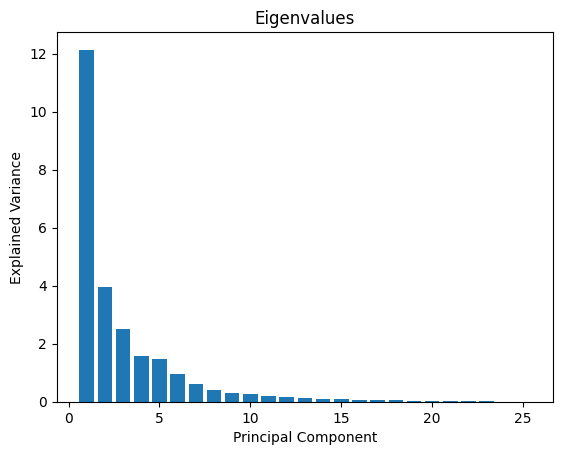

In [25]:

#Plotting the eigen values
plt.bar(range(1, len(eigenvalues) + 1), eigenvalues)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Eigenvalues')
plt.show()


In [110]:

#combining the data frame for input variables and greating lagged value
lagg_for_depend = 1
lagg_for_pca = 1

new_date_index = pd.date_range(start=principal_comp_firstfour.index[-1] + pd.Timedelta(days=1), periods=lagg_for_pca, freq='MS')
new_rows = pd.DataFrame(np.nan, index=new_date_index, columns=["extrarow"])
pcshifted = pd.concat([df_clean_reg, principal_comp_firstfour, new_rows], axis=1).resample('MS').first()
del pcshifted['extrarow'] 
#df_combined_lagged = pd.concat([pcshifted.shift(lagg_for_pca)], axis=1)
df_combined_lagged = pd.concat([pcshifted.shift(lagg_for_pca)], axis=1)#.dropna()
#main data resizing to compensate for the na values

df_clean_reg_resize = df_clean_reg[lagg_for_depend:] #.dropna()
df_combined_lagged_main = df_combined_lagged[lagg_for_depend:] #.dropna()



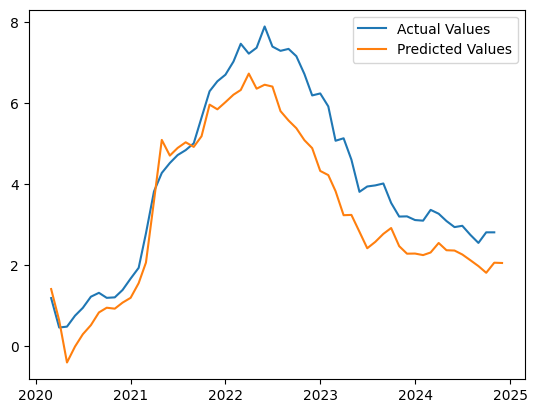

In [111]:
# Split data into training and testing sets (80% training, 20% testing)
train_size = int(len(df_combined_lagged_main) * 0.8)
X_train, X_test = df_combined_lagged_main[:train_size], df_combined_lagged_main[train_size:]
Y_train, Y_test = df_clean_reg_resize[:train_size], df_clean_reg_resize[train_size:]


lr = LinearRegression()
lr.fit(X_train, Y_train)
y_pred = lr.predict(X_test)

y_pred = pd.DataFrame(y_pred, index=X_test.index.values, columns=["Predicted"])

plt.plot(Y_test, label="Actual Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.show()



In [113]:

#summary statistics
import statsmodels.api as sm
log_clf =sm.OLS(Y_test,X_test[:len(Y_test)])
classifier = log_clf.fit()
print(classifier.summary2())


                            Results: Ordinary least squares
Model:                  OLS                        Adj. R-squared (uncentered): 0.997   
Dependent Variable:     _OUTPUT_12MCHNG_USPRIC0001 AIC:                         2.7276  
Date:                   2024-12-02 11:15           BIC:                         12.9428 
No. Observations:       57                         Log-Likelihood:              3.6362  
Df Model:               5                          F-statistic:                 4295.   
Df Residuals:           52                         Prob (F-statistic):          9.70e-67
R-squared (uncentered): 0.998                      Scale:                       0.056492
------------------------------------------------------------------------------------------
                                  Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
------------------------------------------------------------------------------------------
_OUTPUT_12MCHNG_USPRIC0001        0.8898    

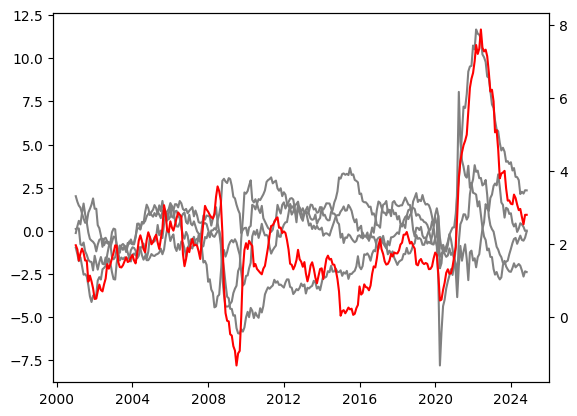

In [ ]:

fig, ax1 = plt.subplots()
ax1.plot(principal_comp.iloc[:, :4], color='gray')
ax2 = ax1.twinx()
ax2.plot(df_clean_reg , color='red')
plt.show()

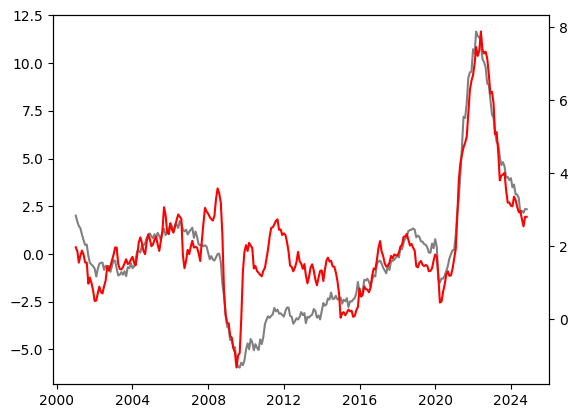

In [ ]:

fig, ax1 = plt.subplots()
ax1.plot(principal_comp.iloc[:, :1], color='gray')
ax2 = ax1.twinx()
ax2.plot(df_clean_reg , color='red')
plt.show()

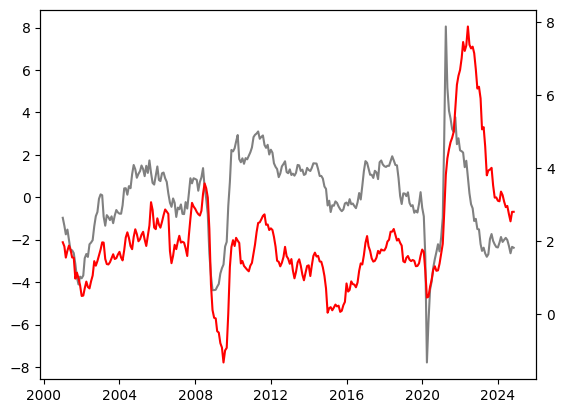

In [ ]:

fig, ax1 = plt.subplots()
ax1.plot(principal_comp.iloc[:, 1:2], color='gray')
ax2 = ax1.twinx()
ax2.plot(df_clean_reg , color='red')
plt.show()

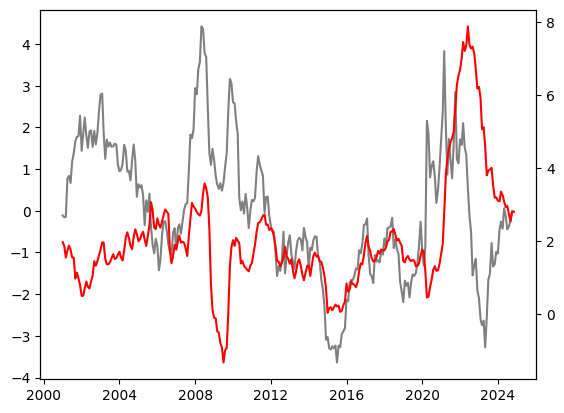

In [ ]:

fig, ax1 = plt.subplots()
ax1.plot(principal_comp.iloc[:, 2:3]*(-1), color='gray')
ax2 = ax1.twinx()
ax2.plot(df_clean_reg , color='red')
plt.show()

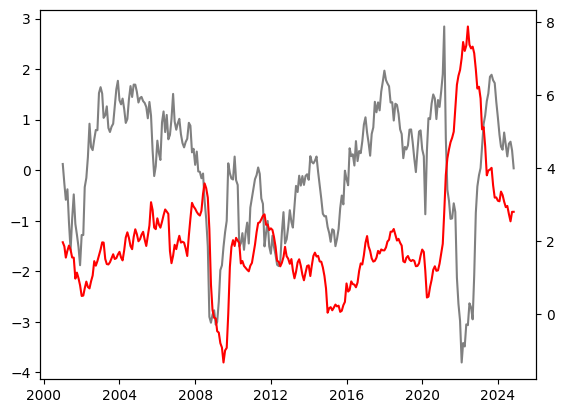

In [ ]:

fig, ax1 = plt.subplots()
ax1.plot(principal_comp.iloc[:, 3:4]*(-1), color='gray')
ax2 = ax1.twinx()
ax2.plot(df_clean_reg , color='red')
plt.show()

C:\Users\tchozin\AppData\Local\Temp\ipykernel_24392\2668881423.py:44: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax2.plot(df_clean_reg.shift(0), 'b', label='PCE (rs)', linestyle='--', color='black')  # Plot on the secondary axis


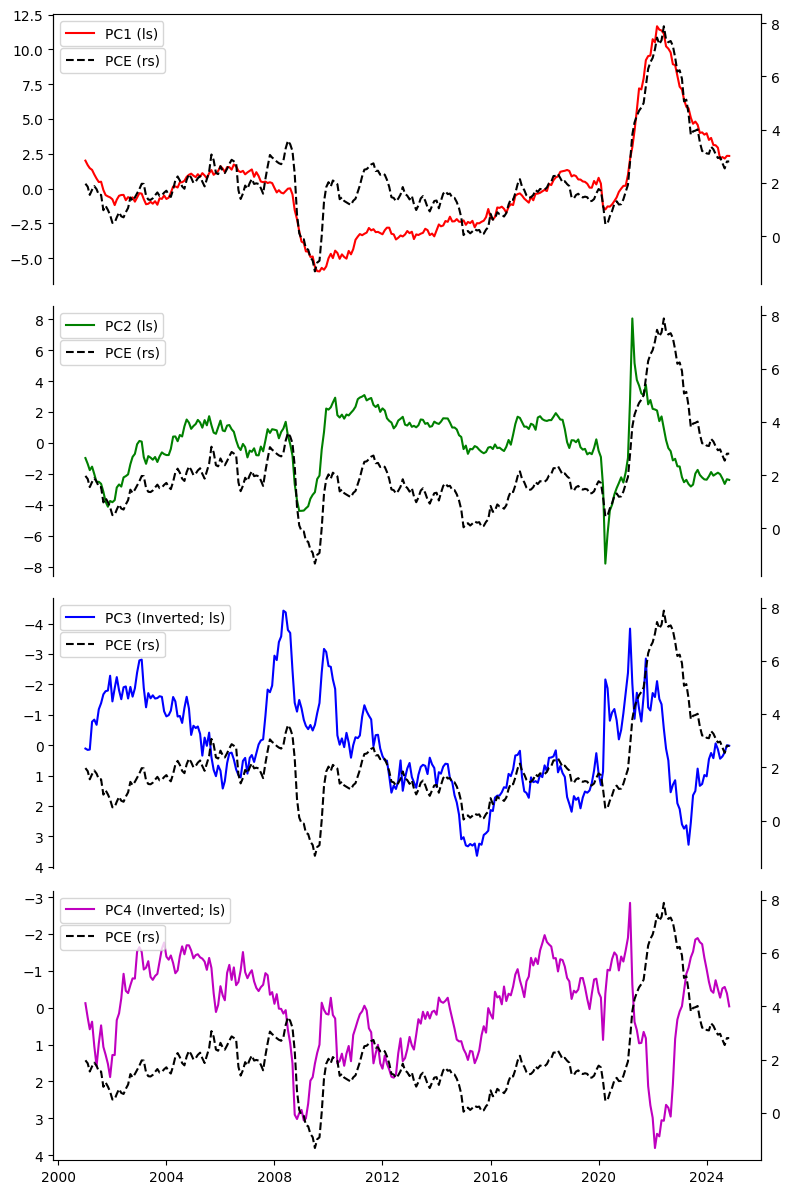

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create some sample data for the plots
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.tan(x)
y4 = np.exp(-x)

# Create a 4x1 grid of subplots (all aligned vertically)
fig, axs = plt.subplots(4, 1, figsize=(8, 12))

# Plot in the first panel (top)
axs[0].plot(principal_comp.iloc[:, :1], 'r', label='PC1 (ls)')
axs[0].spines['bottom'].set_visible(False)
axs[0].set_xticks([])  # Remove x-axis labels for the fourth plot
axs[0].legend(loc='upper left')

# Plot in the second panel
axs[1].plot(principal_comp.iloc[:, 1:2], 'g', label='PC2 (ls)')
axs[1].spines['top'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].set_xticks([])  # Remove x-axis labels for the fourth plot
axs[1].legend(loc='upper left')

# Plot in the third panel
axs[2].plot(principal_comp.iloc[:, 2:3], 'b', label='PC3 (Inverted; ls)')
#axs[2].set_ylim(-10, 10)  # Limit y-axis for tan(x) to avoid extreme values
axs[2].spines['top'].set_visible(False)
axs[2].spines['bottom'].set_visible(False)
axs[2].set_xticks([])  # Remove x-axis labels for the fourth plot
axs[2].legend(loc='upper left')
axs[2].invert_yaxis()
# Plot in the fourth panel (bottom)
axs[3].plot(principal_comp.iloc[:, 3:4], 'm', label='PC4 (Inverted; ls)')
axs[3].spines['top'].set_visible(False)
axs[3].legend(loc='upper left')
axs[3].invert_yaxis()


for i in range(4):
    ax2 = axs[i].twinx()  # Get the secondary axis for each subplot
    ax2.plot(df_clean_reg.shift(0), 'b', label='PCE (rs)', linestyle='--', color='black')  # Plot on the secondary axis
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.legend(loc='upper left',bbox_to_anchor=(0, 0.9))  # Optional: Add a legend for the second series
# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the figure with the four vertically aligned panels
plt.show()

In [ ]:

#combining the data frame for input variables and greating lagged value
lagg_for_depend = 0
lagg_for_pca = 0


new_date_index = pd.date_range(start=principal_comp_firstfour.index[-1] + pd.Timedelta(days=1), periods=lagg_for_pca, freq='MS')
new_rows = pd.DataFrame(np.nan, index=new_date_index, columns=["extrarow"])
pcshifted = pd.concat([principal_comp_firstfour, new_rows], axis=1).resample('MS').first()
del pcshifted['extrarow'] 
df_combined_lagged = pd.concat([pcshifted.shift(lagg_for_pca)], axis=1)

df_combined_lagged




,PC1,PC2,PC3,PC4
2001-01-01,2.009847,-0.969444,0.111964,-0.122400
2001-02-01,1.687437,-1.344896,0.155971,0.269486
2001-03-01,1.469167,-1.750146,0.143784,0.585392
2001-04-01,1.345167,-1.525269,-0.770535,0.378815
2001-05-01,1.016482,-2.005112,-0.839317,1.040839
...,...,...,...,...
2024-07-01,2.135515,-2.015074,0.445419,-0.272783
2024-08-01,2.267577,-2.292191,0.372172,-0.523571
2024-09-01,2.162022,-2.641163,0.236949,-0.563466
2024-10-01,2.354718,-2.338212,0.002556,-0.390693


In [ ]:
#the input variable has a lagged output variable
n = 5
#df_new_lagged = pd.concat([df_clean_reg,principal_comp_firstfour.iloc[:, :1].shift(n)], axis=1)
#df_new_lagged

new_date_index = pd.date_range(start=principal_comp_firstfour.index[-1] + pd.Timedelta(days=1), periods=n, freq='MS')
new_rows = pd.DataFrame(np.nan, index=new_date_index, columns=["extrarow"])
pcshifted = pd.concat([principal_comp_firstfour.iloc[:, :1], new_rows], axis=1).resample('MS').first()
del pcshifted['extrarow'] 
pcshifted.shift(5)

,PC1
2001-01-01,NaN
2001-02-01,NaN
2001-03-01,NaN
2001-04-01,NaN
2001-05-01,NaN
...,...
2024-12-01,2.135515
2025-01-01,2.267577
2025-02-01,2.162022
2025-03-01,2.354718
